In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

## 1: Load and Merge the Dataset

In [2]:
true_news_df = pd.read_csv('../data/raw/True.csv')
fake_new_df = pd.read_csv('../data/raw/Fake.csv')

In [3]:
true_news_df.isna().sum(), fake_new_df.isna().sum()

(title      0
 text       0
 subject    0
 date       0
 dtype: int64,
 title      0
 text       0
 subject    0
 date       0
 dtype: int64)

In [4]:
fake_new_df.loc[:, 'date'] = pd.to_datetime(fake_new_df['date'],format='mixed' , errors='coerce')

In [5]:
fake_new_df.isna().sum()

title       0
text        0
subject     0
date       10
dtype: int64


- **Noise Removal:**  
  Removed noisy and incomplete records (e.g., rows with missing or malformed dates).

In [6]:
fake_new_df[fake_new_df.date.isna()]

,title,text,subject,date
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT


These are some random noisey data in the dataset. Let's drop these data.

In [7]:
# let's drop these data

fake_new_df.dropna(axis=0,  how='any', inplace=True)

In [8]:
true_news_df.loc[:, 'date'] = pd.to_datetime(true_news_df['date'],format='mixed' , errors='coerce')


In [9]:
true_news_df.isna().sum(), fake_new_df.isna().sum()

(title      0
 text       0
 subject    0
 date       0
 dtype: int64,
 title      0
 text       0
 subject    0
 date       0
 dtype: int64)

In [10]:
true_news_df['label'] =0 # True News
fake_new_df['label'] = 1 # Fake News

# Combine
df = pd.concat([fake_new_df, true_news_df]).sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
df.sample(10)

,title,text,subject,date,label
31765,BREAKING: SUPREME COURT BLOCKS TEXAS ABORTION ...,Wow! The liberal Supreme Court s really making...,Government News,2015-06-29 00:00:00,1
23113,Thanksgiving Day Fake News Turkey Shoot: Boile...,Tune in to the Alternate Current Radio Network...,US_News,2017-11-26 00:00:00,1
29101,Russian frigate fires cruise missiles at Islam...,MOSCOW (Reuters) - The Russian frigate Admiral...,worldnews,2017-09-05 00:00:00,0
36290,Republican senator says it appears will be no ...,WASHINGTON (Reuters) - Republican Senator Pat ...,politicsNews,2017-09-26 00:00:00,0
41512,Boiler Room EP #121 – Google vs The Red Pill &...,Tune in to the Alternate Current Radio Network...,US_News,2017-08-11 00:00:00,1
7188,Couple Married 37 Years In Disagreement On El...,This election is bringing out all kinds of emo...,News,2016-11-08 00:00:00,1
24845,What's a 'dotard' anyway? Kim's insult to Trump,(Reuters) - North Korean leader Kim Jong Un ha...,worldnews,2017-09-22 00:00:00,0
12693,No U.S.-Russia cyber unit without Trump notify...,(Reuters) - U.S. President Donald Trump would ...,politicsNews,2017-08-23 00:00:00,0
10823,Allen West Tries To Hide Desire To Exterminat...,"Well, this came back to bite Allen West on the...",News,2016-12-11 00:00:00,1
32865,LOL! UN Refugee Spokes-Celebrity ANGELINA JOLI...,Great advice from a woman who has 24-7 securit...,left-news,2016-05-16 00:00:00,1




## 2 **Initial Loading & Inspection:**  
  Loaded raw datasets for real and fake news, checked for missing values, and standardized date formats.




In [12]:
df.shape

(44888, 5)

In [13]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [14]:
df.sample(10)

,title,text,subject,date,label
17013,Maltese prime minister promises reward to unco...,VALLETTA (Reuters) - Prime Minister Joseph Mus...,worldnews,2017-10-18 00:00:00,0
33950,"Iraq to pay Kurdish Peshmerga, civil servants,...",BAGHDAD (Reuters) - The Iraqi government plans...,worldnews,2017-10-31 00:00:00,0
12054,"Troops and strays, the only signs of life in r...","MARAWI CITY, Philippines (Reuters) - With vehi...",worldnews,2017-10-25 00:00:00,0
30696,"Report shows 1,300 unfilled jobs, strain for G...",BERLIN (Reuters) - The German military s procu...,worldnews,2017-12-13 00:00:00,0
30477,Republican Greg Abbott Picks Supporting Israe...,Governor Greg Abbott of Texas recently travele...,News,2016-01-18 00:00:00,1
35345,Factbox: Trump on Twitter (Aug 1) - Stock mark...,The following statements were posted to the ve...,politicsNews,2017-08-01 00:00:00,0
3386,Why Conservatives Need To Stop Whining About ...,"Terrorists attacked Brussels, Belgium in a tra...",News,2016-03-22 00:00:00,1
29235,Jealous Donald Trump Attacks Megyn Kelly Agai...,After Megyn Kelly shut down his attempts to wo...,News,2016-01-11 00:00:00,1
4344,Trump Supporter Threatens Montel Williams So ...,Montel Williams is an outspoken opponent of Do...,News,2016-10-14 00:00:00,1
41498,LOL! DESPERATE KATHY GRIFFIN Makes Home Video ...,Wow! Poor Kathy Griffin The toxic comedian f...,left-news,2017-11-19 00:00:00,1


In [15]:
df.describe(include='all')


C:\Users\regmi\AppData\Local\Temp\ipykernel_13728\1192053151.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df.describe(include='all')


,title,text,subject,date,label
count,44888,44888,44888,44888,44888.000000
unique,38723,38640,8,1010,NaN
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,2017-12-20 00:00:00,NaN
freq,14,627,11272,197,NaN
mean,NaN,NaN,NaN,NaN,0.522879
std,NaN,NaN,NaN,NaN,0.499482
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,1.000000


### 2.1: Checking For Null Values

In [16]:
df.info()
print("\n Null Values \n",df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44888 entries, 0 to 44887
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44888 non-null  object
 1   text     44888 non-null  object
 2   subject  44888 non-null  object
 3   date     44888 non-null  object
 4   label    44888 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB

 Null Values 
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


<div style=" border-left: 4px solid #007acc; padding: 16px; margin-bottom: 12px;">

**Data Quality Check:**  
There are no missing values in the dataset.  
Next, let's examine if there are any duplicate rows present.

</div>

In [17]:
df = df.drop(6408)

In [18]:
df['date'] = pd.to_datetime(df['date'], format='mixed',errors='coerce')

In [19]:
df[df.isna()]

,title,text,subject,date,label
0,NaN,NaN,NaN,NaT,NaN
1,NaN,NaN,NaN,NaT,NaN
2,NaN,NaN,NaN,NaT,NaN
3,NaN,NaN,NaN,NaT,NaN
4,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...
44883,NaN,NaN,NaN,NaT,NaN
44884,NaN,NaN,NaN,NaT,NaN
44885,NaN,NaN,NaN,NaT,NaN
44886,NaN,NaN,NaN,NaT,NaN


### 2.2: Checking for Duplicates

Fully duplicated rows: 405


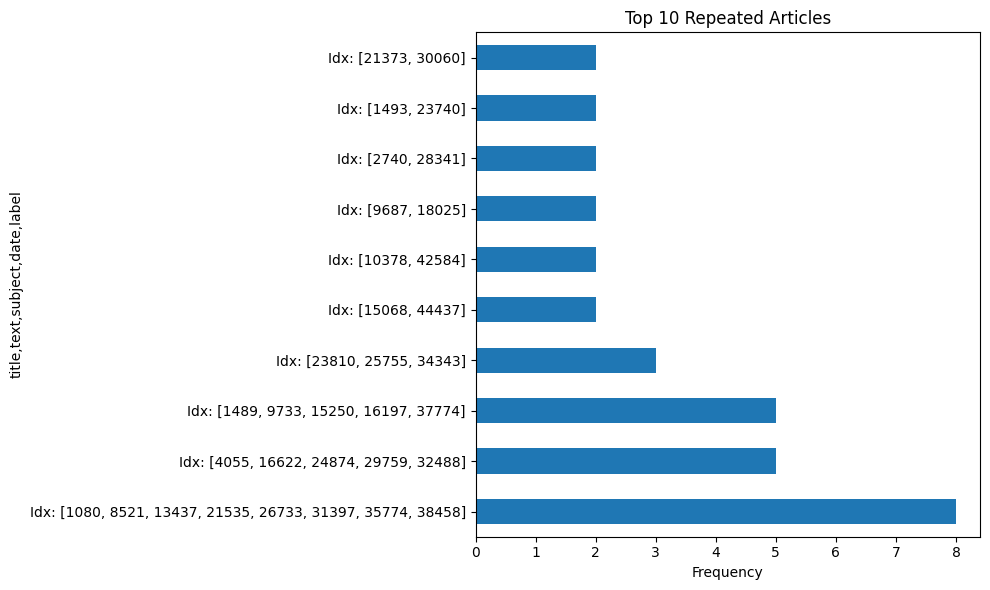

In [20]:
# Detect fully duplicated rows
full_duplicates = df[df.duplicated(keep=False)]

print(f"Fully duplicated rows: {full_duplicates.shape[0]}")

# Visualize top repeated articles with their indices
top_duplicates = full_duplicates.value_counts().head(10)
top_indices = [full_duplicates[(full_duplicates == row).all(axis=1)].index.tolist() for row in top_duplicates.index]
labels = [f"Idx: {inds}" for inds in top_indices]

top_duplicates.plot(kind='barh', figsize=(10,6), title='Top 10 Repeated Articles')
plt.xlabel("Frequency")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.tight_layout()
plt.show()


In [21]:
# Duplicate based only on 'text' column
text_duplicates = df[df.duplicated(subset='text', keep=False)]

print(f"Articles with duplicated text: {text_duplicates.shape[0]}")

# Optional: Show label disagreement on same text
label_conflict = text_duplicates.groupby('text')['label'].nunique()
conflicts = label_conflict[label_conflict > 1]
print(f"Texts with conflicting labels: {conflicts.shape[0]}")


Articles with duplicated text: 11386
Texts with conflicting labels: 1


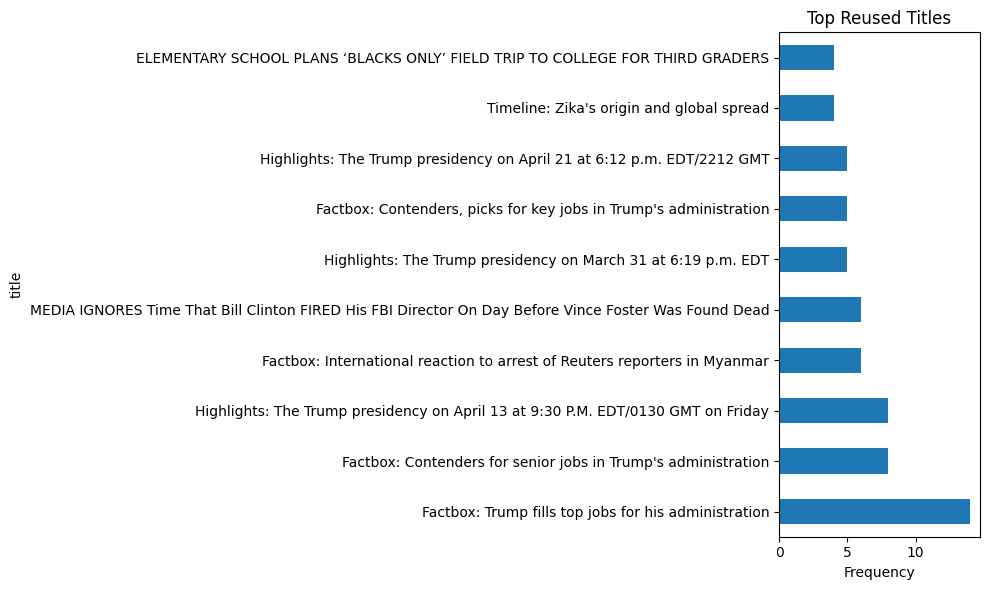

In [22]:
title_dupes = df[df.duplicated(subset='title', keep=False)]

# Top reused titles
top_titles = title_dupes['title'].value_counts().head(10)
top_titles.plot(kind='barh', figsize=(10,6), title='Top Reused Titles')
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()



####  **Duplicate Handling Summary**

1. **Remove Fully Identical Rows**  
   - Eliminated rows that are exact duplicates across *all* columns to remove redundant data.

2. **Remove Duplicate Entries with Same Text and Label**  
   - For entries with identical `'text'` and `'label'`, kept only the most recent based on `'date'`.  
   - This preserves cases where the same text is labeled differently, avoiding accidental data loss and maintaining label diversity.

3. **Remove Conflicting Labels on Same Text**  
   - Identified texts that have multiple differing labels and removed all such entries to ensure label consistency and prevent model confusion.

---
####  **Outcome**

- Dataset redundancy is reduced while preserving meaningful variations in labeling.  
- Label conflicts are eliminated, improving dataset quality for more reliable model training.  
- The cleaning pipeline strikes a balance between data quantity and data integrity.


In [23]:
# Backup original dataset
df_original = df.copy()

# STEP 1: Drop fully identical rows
df_step1 = df.drop_duplicates()
removed_full_duplicates = df_original.shape[0] - df_step1.shape[0]
print(f"Step 1 - Removed fully duplicated rows: {removed_full_duplicates}")

# STEP 2: Remove duplicates where both 'text' and 'label' are the same, keep latest by 'date'
df_step1.loc[:, 'date'] = pd.to_datetime(df_step1['date'], errors='coerce')
df_step2 = df_step1.sort_values('date').drop_duplicates(subset=['text', 'label'], keep='last')
removed_text_label_duplicates = df_step1.shape[0] - df_step2.shape[0]
print(f"Step 2 - Removed duplicates with same 'text' and 'label' (kept latest): {removed_text_label_duplicates}")

# STEP 3: Remove entries with conflicting labels for the same 'text'
label_conflicts = df_step2.groupby('text')['label'].nunique()
conflicted_texts = label_conflicts[label_conflicts > 1].index
df_final = df_step2[~df_step2['text'].isin(conflicted_texts)].copy()  
removed_label_conflicts = df_step2.shape[0] - df_final.shape[0]
print(f"Step 3 - Removed entries with conflicting labels on same text: {removed_label_conflicts}")

# FINAL SUMMARY
total_removed = removed_full_duplicates + removed_text_label_duplicates + removed_label_conflicts
print(f"\n Total records removed after all steps: {total_removed}")
print(f" Final dataset shape: {df_final.shape}")


Step 1 - Removed fully duplicated rows: 209
Step 2 - Removed duplicates with same 'text' and 'label' (kept latest): 6038
Step 3 - Removed entries with conflicting labels on same text: 2

 Total records removed after all steps: 6249
 Final dataset shape: (38638, 5)


In [24]:
df_final.sample(10)

,title,text,subject,date,label
28385,U.S. lawmaker acknowledges corporate lobbying ...,WASHINGTON (Reuters) - An aggressive corporate...,politicsNews,2017-07-19,0
29049,Amnesty says China detains 30 relatives of exi...,BEIJING (Reuters) - Authorities in China s far...,worldnews,2017-11-14,0
26460,Abe to push reform of Japan's pacifist constit...,TOKYO (Reuters) - Japanese Prime Minister Shin...,worldnews,2017-10-21,0
29888,WATCH: GOP REP DAVE BRAT TURNED TABLES On #Fak...,"During a Friday interview, Virginia Rep. Dave ...",politics,2017-07-14,1
43461,Turkey's release of German citizen sign of tha...,BERLIN (Reuters) - Turkey s decision to releas...,worldnews,2017-10-26,0
36780,"Germany calls for restraint, dialogue in Zimbabwe",BERLIN (Reuters) - Germany called for all side...,worldnews,2017-11-15,0
44165,Samsung leader Jay Y. Lee given five-year jail...,SEOUL (Reuters) - The billionaire head of Sout...,worldnews,2017-08-24,0
20923,Vatican says investigating alleged abuser who ...,VATICAN CITY (Reuters) - The Vatican said on S...,worldnews,2017-11-18,0
27763,WOW! IS MEGHAN MCCAIN FINISHED With The Hatefu...,It s pretty common knowledge for anyone s who ...,left-news,2017-11-17,1
16849,Boiler Room EP #117 – Straight Outta Tavistock...,Tune in to the Alternate Current Radio Network...,US_News,2017-07-14,1


## 3: Analyzing the class balance

Class counts:
label
0    21191
1    17447
Name: count, dtype: int64


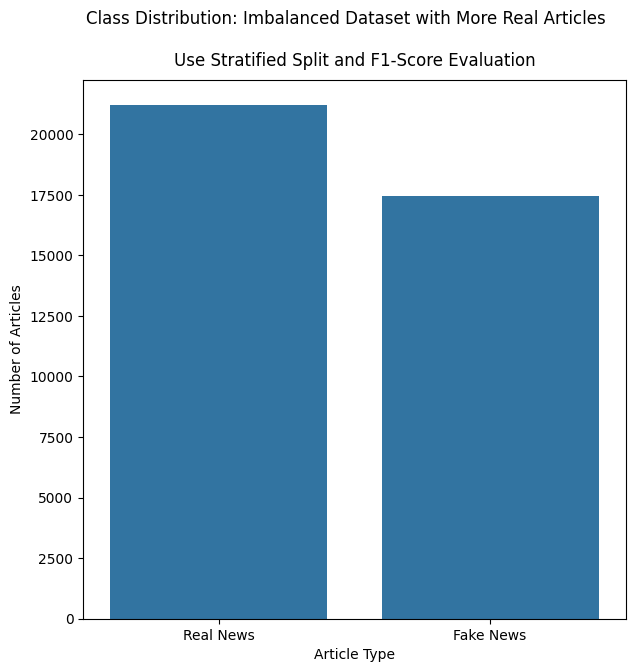

In [25]:
# Count number of samples per label
class_counts = df_final['label'].value_counts()

print("Class counts:")
print(class_counts)

# Map label values to meaningful names
label_names = {0: 'Real News', 1: 'Fake News'}

# Plot class distribution with labeled x-ticks
plt.figure(figsize=(7,7))
sns.barplot(x=[label_names[i] for i in class_counts.index], y=class_counts.values)
plt.suptitle("Class Distribution: Imbalanced Dataset with More Real Articles\n", fontsize=12)
plt.title("Use Stratified Split and F1-Score Evaluation", pad=10)
plt.xlabel("Article Type")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.savefig('../reports/figures/class_distribution.jpg')
plt.show()


## 4: Metadata Feature Engineering

To enhance the dataset's predictive power and interpretability, several metadata features were engineered:

1. **Article and Title Length**  
   - Quantifies the length of articles and headlines to capture structural differences (e.g., fake news tends to be longer and more variable).

2. **Punctuation Counts (`!`, `?`)**  
   - Measures the frequency of exclamation and question marks, which are often used in sensational or emotionally charged writing.

3. **All Uppercase Word Count**  
   - Counts fully uppercase words to detect shouting or attention-grabbing language, a common trait in fake news.

4. **Day of Week from Date**  
   - Extracts the day of the week to analyze publishing patterns (e.g., fake news spikes on weekends).



In [26]:
# Calculate text and title lengths
df_final['text_length'] = df_final['text'].apply(len)
df_final['title_length'] = df_final['title'].apply(len)

# Count punctuation marks
df_final['exclamations_mark_count'] = df_final['text'].str.count('!')
df_final['questions_mark_count'] = df_final['text'].str.count(r'\?')

# Count fully uppercase words
df_final['uppercase_words_count'] = df_final['text'].apply(
    lambda x: sum(1 for w in x.split() if w.isupper())
)

# Ensure 'date' column is in datetime format
df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')

# Extract day of the week from the 'date' column
df_final['day_of_week'] = df_final['date'].dt.day_name()

In [27]:
df_final.head(10)

,title,text,subject,date,label,text_length,title_length,exclamations_mark_count,questions_mark_count,uppercase_words_count,day_of_week
38938,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,2015-03-31,1,1245,130,0,0,4,Tuesday
9407,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,1,3157,117,0,5,14,Tuesday
2119,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,politics,2015-03-31,1,1994,76,0,1,0,Tuesday
32635,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",left-news,2015-03-31,1,658,80,0,1,4,Tuesday
17073,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,1,2488,49,0,4,5,Tuesday
26484,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,1,8377,59,0,0,2,Tuesday
31354,MUSLIM WOMAN ARRESTED FOR SPITTING ON HER FELL...,This woman s having trouble entering the Walma...,politics,2015-04-01,1,1986,111,1,0,14,Wednesday
1596,“Non-violence hasn’t worked”…Reverend Sam Most...,Yeah that whole taking up arms thing seems t...,left-news,2015-04-01,1,1728,115,0,2,10,Wednesday
14957,IS ISIS IN DANGER OF BEING WIPED OUT BY A FLES...,Try to fix that with a dull knife boys The sel...,politics,2015-04-02,1,1396,61,0,0,3,Thursday
43416,FED’S PREVENT ‘Mother of the Year’ From Boardi...,There are just way too many wannabe male and f...,politics,2015-04-04,1,1480,123,0,0,4,Saturday


## 5: Performing Visual Explorations

### 5.1: Which subject has more fake new?

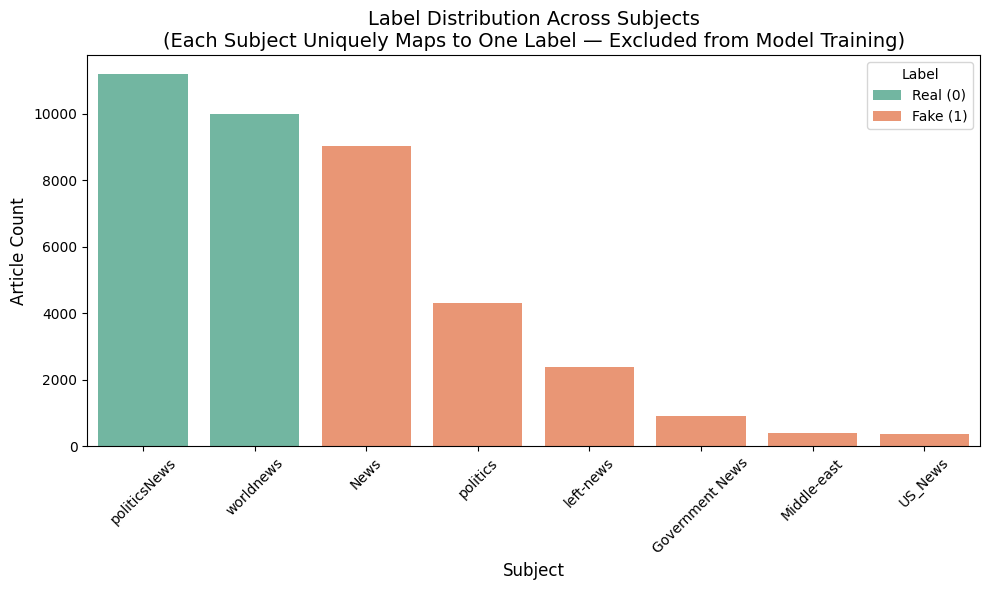

In [28]:
plt.figure(figsize=(10,6))


sns.countplot(
    data=df_final, 
    x='subject', 
    hue='label', 
    order=df_final['subject'].value_counts().index,
    palette='Set2'
)

# Main title and subtitle with reasoning
plt.title(
    "Label Distribution Across Subjects\n(Each Subject Uniquely Maps to One Label — Excluded from Model Training)",
    fontsize=14
)

plt.xlabel("Subject", fontsize=12)
plt.ylabel("Article Count", fontsize=12)
plt.xticks(rotation=45)

# Legend
plt.legend(title='Label', labels=['Real (0)', 'Fake (1)'])

plt.tight_layout()
plt.savefig('../reports/figures/label_distribution_accross_subjects.jpg')
plt.show()


####  Summary of the subject column

> We observed that the `subject` column is perfectly aligned with the target `label`. Categories like `'left-news'`, `'politics'`, etc. contain only fake news, while `'worldnews'` and `'politicsNews'` contain only real news. This introduces a strong risk of **data leakage**, and therefore, we chose to exclude the `subject` feature from model training. It may still be used for exploratory analysis.




In [29]:
df_final.subject.unique()

array(['politics', 'left-news', 'Government News', 'News', 'US_News',
       'politicsNews', 'Middle-east', 'worldnews'], dtype=object)

### 5.2 How does the distribution of title_length varies accross different labels?

In [30]:
def plot_label_distribution(df, x, y, title, file_location):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
    plt.suptitle(title, fontsize=14)
    
    # Box Plot
    sns.boxplot(data=df, x=df[x], y=df[y], ax=axes[0], palette='Set2', hue=df[x])
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Real (0)', 'Fake (1)'])
    axes[0].set_xlabel("News")
    axes[0].set_ylabel(y.replace('_', ' ').title())
    
    # Histogram / KDE
    sns.histplot(data=df, x=df[y], hue=df[x], kde=True, ax=axes[1],
                 element='step', stat='density', common_norm=False, palette='Set2')
    axes[1].set_xlabel(y.replace('_', ' ').title())
    axes[1].set_ylabel("Density")
    
    plt.tight_layout()
    plt.savefig(file_location)
    plt.show()


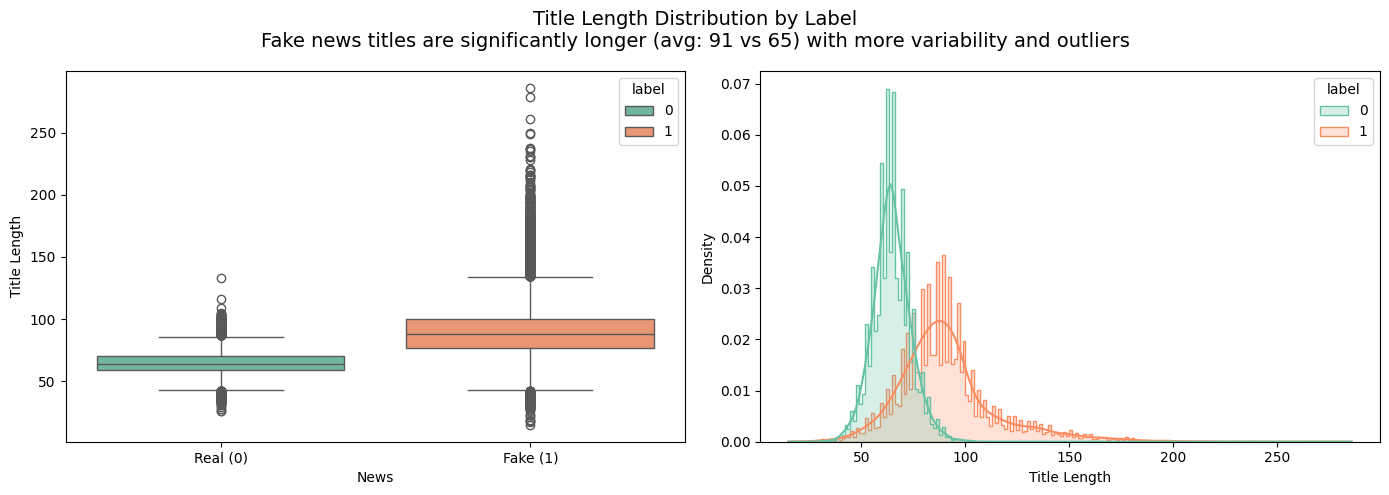

In [31]:
plot_label_distribution(df_final,
                        x='label',
                        y='title_length',
                        title=   ( "Title Length Distribution by Label\n"
    "Fake news titles are significantly longer (avg: 91 vs 65) with more variability and outliers"),
                        file_location='../reports/figures/title_length_distribution_by_label.jpg'
                        )

In [32]:
print(df_final.groupby('label')['title_length'].describe())

         count       mean        std   min   25%   50%    75%    max
label                                                               
0      21191.0  64.661130   9.158640  26.0  59.0  64.0   70.0  133.0
1      17447.0  91.218605  24.506116  15.0  77.0  88.0  100.0  286.0



####  Summary: Title Length vs. News Label

* **Fake news titles** are, on average, **significantly longer** than real news titles (91 vs. 65 characters).
* They also show **greater variability** (std: 24.5 vs. 9.1) and more **extreme outliers**, reaching up to 286 characters.
* In contrast, **real news titles** are more consistent in length and tightly clustered around the median.
* This suggests that **sensational or verbose headlines** may be a distinguishing trait of fake news articles.



### 5.2 How does the distribution of text_length varies accross different labels?

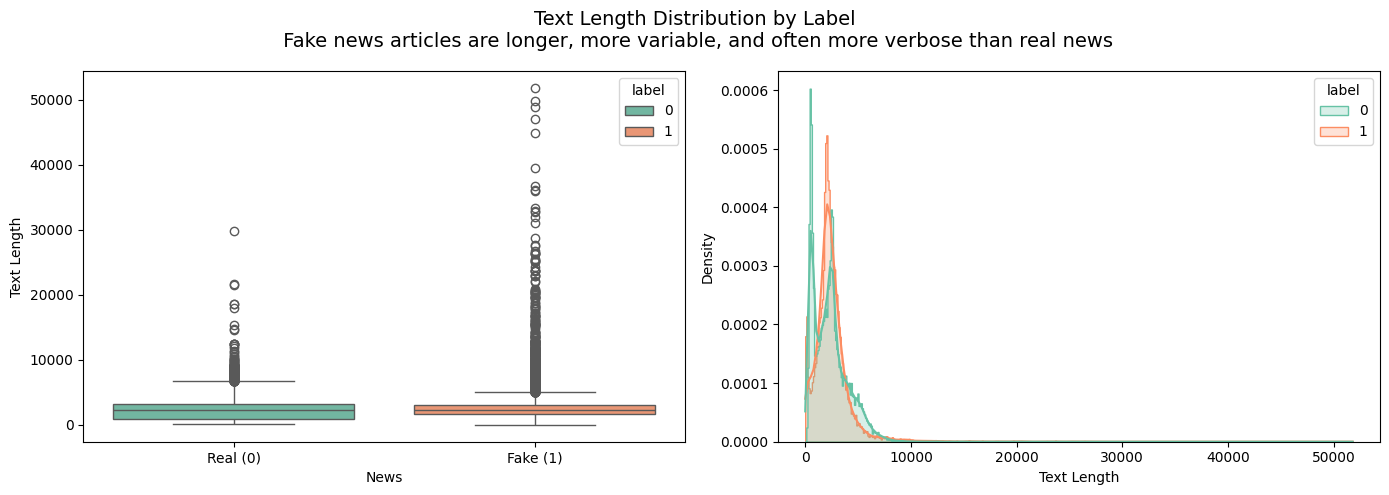

In [33]:
plot_label_distribution(
    df_final,
    x='label',
    y='text_length',
    title=("Text Length Distribution by Label\n Fake news articles are longer, more variable, and often more verbose than real news"),
    file_location='../reports/figures/text_length_distribution_by_label.jpg'
)

In [43]:
print(df_final.groupby('label')['text_length'].describe())


         count         mean          std    min     25%     50%     75%  \
label                                                                     
0      21191.0  2378.527158  1683.781664  152.0   906.5  2216.0  3226.5   
1      17447.0  2550.777899  2201.307780    2.0  1650.0  2235.0  3006.0   

           max  
label           
0      29781.0  
1      51794.0  


####  Summary: Text Length vs. News Label

* **Fake news articles** (label = 1) have **slightly longer average text length** (2,549 vs. 2,379 characters for real news).
* They exhibit **greater variability** (std: 2,201 vs. 1,684), with extreme lengths reaching up to 51,794 characters for fake articles and 29,781 for real.
* **Real news** (label = 0) is more consistent, with articles typically ranging between 900 and 3,226 characters.
* The **wider distribution and higher max values** in fake news suggest that these articles are more likely to contain longer, verbose content.




### 5.3: Does Punctatuation affect the News Label?

In [44]:
df_final.columns

Index(['title', 'text', 'subject', 'date', 'label', 'text_length',
       'title_length', 'exclamations_mark_count', 'questions_mark_count',
       'uppercase_words_count', 'day_of_week'],
      dtype='object')

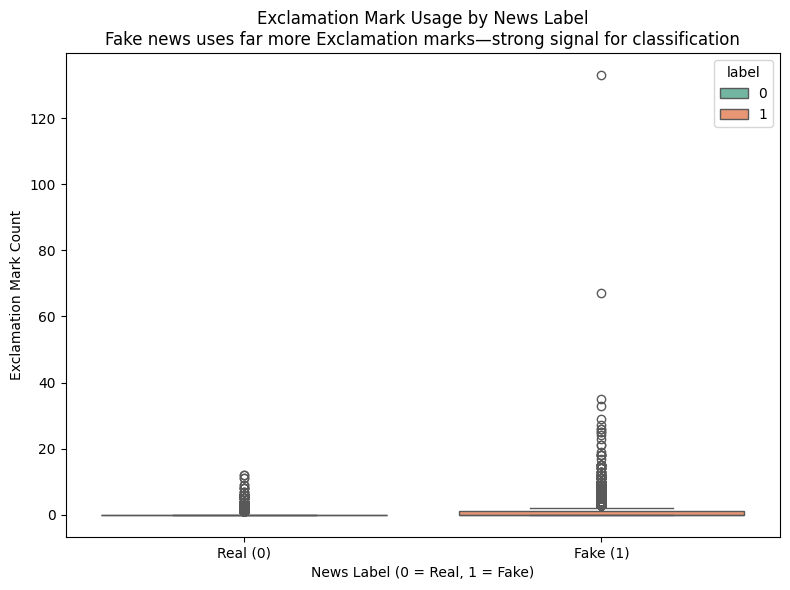

In [34]:


plt.figure(figsize=(8, 6))
sns.boxplot(data=df_final, x='label', y='exclamations_mark_count', hue='label', palette='Set2')
plt.title("Exclamation Mark Usage by News Label\nFake news uses far more Exclamation marks—strong signal for classification")
plt.xlabel("News Label (0 = Real, 1 = Fake)")
plt.ylabel("Exclamation Mark Count")
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.savefig('../reports/figures/exclamation_mark_usage_by_news_label')
plt.show()

In [46]:
print(df_final.groupby('label')['exclamations_mark_count'].describe())


         count      mean       std  min  25%  50%  75%    max
label                                                        
0      21191.0  0.062149  0.419282  0.0  0.0  0.0  0.0   12.0
1      17447.0  0.741961  2.005614  0.0  0.0  0.0  1.0  133.0


In [47]:
df_final[df['label']==0]['exclamations_mark_count'].unique()

C:\Users\regmi\AppData\Local\Temp\ipykernel_14604\138898062.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_final[df['label']==0]['exclamations_mark_count'].unique()


array([ 0,  2,  1,  3,  4,  5,  7,  8,  6, 11, 12,  9])

In [48]:
df_final[df['label']==1]['exclamations_mark_count'].unique()


C:\Users\regmi\AppData\Local\Temp\ipykernel_14604\1268401062.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_final[df['label']==1]['exclamations_mark_count'].unique()


array([  0,   1,  18,   2,   3,   5,   4,   6,   7,  10,   9,   8,  24,
        11,  14,  12,  15,  13,  33,  67,  25,  23, 133,  35,  29,  21,
        19,  26,  17,  27])

####  Summary: Exclamation Mark Count vs News Label

* **Real News (label = 0)**:

  * Very low usage of exclamation marks (mean ≈ 0.06).
  * 75% of articles have **0 exclamations**.
  * Max count is **12**, rare outliers.

* **Fake News (label = 1)**:

  * Significantly higher usage (mean ≈ 0.74).
  * 25% of articles have **more than 1** exclamation.
  * Max count is **133**, showing extreme outliers.
  * Greater spread and variability (std ≈ 2.0).

*  **Insight**: **Exclamation marks are much more frequent in fake news**, making this a strong feature for classification.




#### Feature: `exclamations_mark_count`

* **Description:** Number of exclamation marks in news text; higher in fake news.
* **Stats:**

  * Real news mean ≈ 0.06 (max 12)
  * Fake news mean ≈ 0.74 (max 133, extreme outliers present)

#### Outlier Handling & Model Use

| Model       | Treatment                | Reason                              |
| ----------- | ------------------------ | ----------------------------------- |
| Naive Bayes | Log-transform (`log1p`)  | Reduces skew and impact of outliers |
| SVM         | Log-transform + scaling  | Sensitive to scale and outliers     |
| XGBoost     | Use raw values (or both) | Tree models handle outliers well    |

---

**Summary:** Keep raw counts for XGBoost, log-transform for Naive Bayes and SVM to improve model robustness.

---



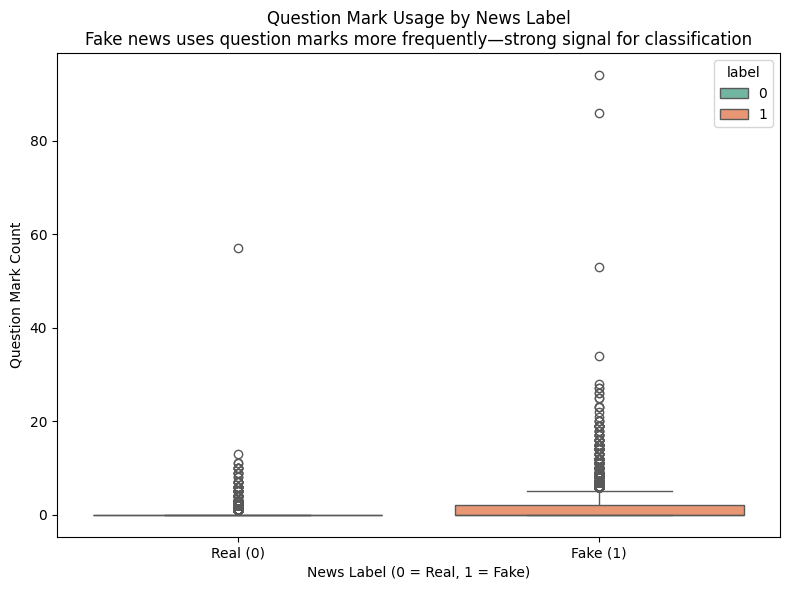

In [91]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_final, x='label', y='questions_mark_count', hue='label', palette='Set2')
plt.title("Question Mark Usage by News Label\nFake news uses question marks more frequently—strong signal for classification")
plt.xlabel("News Label (0 = Real, 1 = Fake)")
plt.ylabel("Question Mark Count")
plt.xticks([0, 1], ['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.savefig('../reports/figures/question_mark_usage_by_news_label')

plt.show()

In [50]:
print(df_final.groupby('label')['questions_mark_count'].describe())


         count      mean       std  min  25%  50%  75%   max
label                                                       
0      21191.0  0.099995  0.629130  0.0  0.0  0.0  0.0  57.0
1      17447.0  1.233450  2.340035  0.0  0.0  0.0  2.0  94.0


#### Summary: Question Mark Count vs News Label

* **Real News (label = 0)**:

  * Low usage of question marks (mean ≈ 0.10).
  * 75% of articles have **0 question marks**.
  * Max count is **57**, with some outliers.

* **Fake News (label = 1)**:

  * Much higher usage (mean ≈ 1.23).
  * 25% of articles have **more than 2 question marks**.
  * Max count is **94**, showing extreme outliers.
  * Greater variability (std ≈ 2.34).

* **Insight**: **Fake news tends to use question marks more frequently**, which may help in distinguishing it from real news.



### 5.4 How does upper case count affect the label?

In [51]:
df_final.columns

Index(['title', 'text', 'subject', 'date', 'label', 'text_length',
       'title_length', 'exclamations_mark_count', 'questions_mark_count',
       'uppercase_words_count', 'day_of_week'],
      dtype='object')

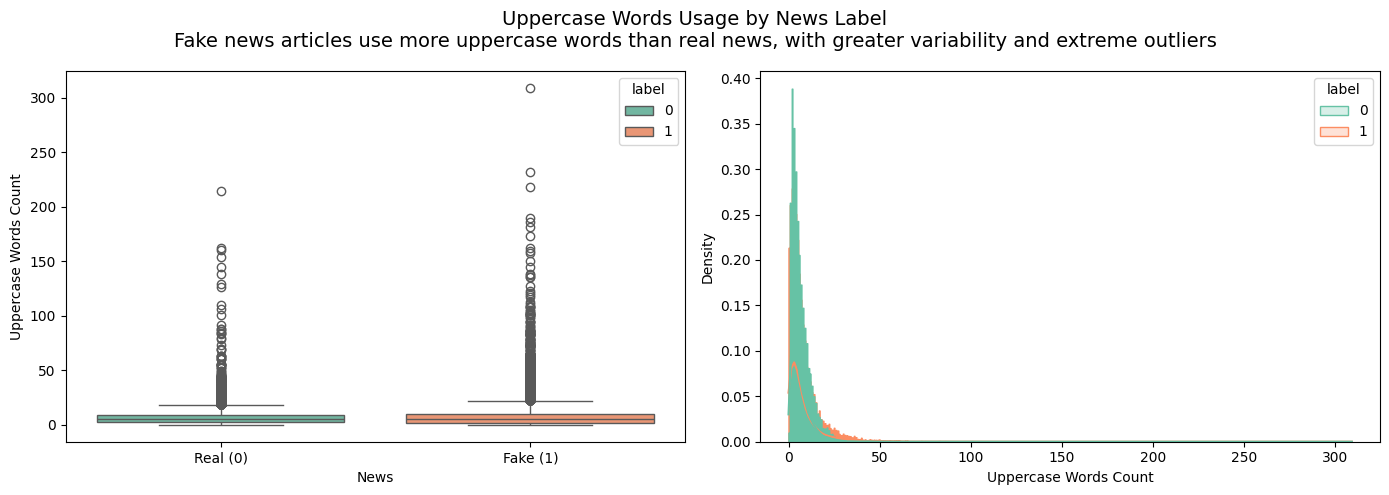

In [93]:
plot_label_distribution(df_final, x='label', y='uppercase_words_count', 
                        title=('Uppercase Words Usage by News Label\nFake news articles use more uppercase words than real news, with greater variability and extreme outliers')
                        ,file_location='../reports/figures/uppercase_word_usage_by_news_label'
                        )

In [53]:
print(df_final.groupby('label')['uppercase_words_count'].describe())


         count      mean        std  min  25%  50%   75%    max
label                                                          
0      21191.0  6.710868   6.818684  0.0  3.0  5.0   9.0  214.0
1      17447.0  8.391070  11.719805  0.0  2.0  5.0  10.0  309.0



#### Summary: Uppercase Words Count vs News Label

* **Real News (label = 0)**:

  * Average of \~6.7 uppercase words per article.
  * 75% of articles contain **9 or fewer** uppercase words.
  * Max value: **214** (rare outliers).

* **Fake News (label = 1)**:

  * Higher average: \~8.4 uppercase words.
  * 75% of articles contain **10 or fewer**.
  * Max value: **309**, indicating more extreme cases.
  * Greater variability (std ≈ 11.7 vs. 6.8 in real news).

* **Insight**: Fake news tends to use **more uppercase words**, possibly to **emphasize or sensationalize content** (e.g., headlines like “BREAKING” or “SHOCKING”). This pattern can be a useful metadata feature in classification.



In [54]:
df_final.sample(10)

,title,text,subject,date,label,text_length,title_length,exclamations_mark_count,questions_mark_count,uppercase_words_count,day_of_week
37881,The Cast Of ‘Will & Grace’ Just SHREDDED Trum...,By now we ve all heard about or seen the cast ...,News,2016-10-31,1,1781,82,3,3,2,Monday
9675,Republicans Look To Shut Down The Government ...,Republicans won the 2016 presidential electi...,News,2016-12-09,1,3524,85,0,4,0,Friday
941,U.S. corporate alternative minimum tax should ...,WASHINGTON (Reuters) - The alternative minimum...,politicsNews,2017-12-04,0,521,74,0,0,5,Monday
5145,Afghan Taliban say kidnapped U.S. professor is...,KABUL (Reuters) - The Afghan Taliban said on M...,worldnews,2017-10-30,0,1767,60,0,0,2,Monday
508,"U.S. lawmakers want more Iran sanctions, but c...",WASHINGTON (Reuters) - A senior U.S. senator s...,politicsNews,2016-06-07,0,2460,56,0,0,4,Tuesday
33906,OBAMA’S EMBARRASSING Farewell Interview: Mom W...,We all know the rules are a little different f...,left-news,2016-12-26,1,4323,142,0,0,13,Monday
3735,WATCH: Sean Spicer’s Debut in “The Bold and t...,President Donald Trump has made one thing clea...,News,2017-04-26,1,962,92,0,0,1,Wednesday
33716,Lawrence O’Donnell Reveals What Would Happen ...,Donald Trump is a liar. This is pretty well-es...,News,2016-09-17,1,2665,86,0,3,11,Saturday
10497,Beijing seen poised for fresh South China Sea ...,HONG KONG/BEIJING (Reuters) - China has quietl...,worldnews,2017-10-31,0,5624,59,0,0,14,Tuesday
28774,"Zimbabwe's Mugabe widens purge, clearing wife'...",HARARE (Reuters) - Zimbabwean President Robert...,worldnews,2017-11-07,0,2675,63,0,0,14,Tuesday


### 5.4: How does the News Labels varies according to different days in a week?

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image

# Prepare data as before
day_based_news = pd.crosstab(index=df_final['day_of_week'], columns=df_final['label'])
day_based_news.columns = ['Real (0)', 'Fake (1)']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_based_news = day_based_news.reindex(day_order)

# Create subplot figure: 4 columns, 2 rows (7 days)
fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=day_based_news.index.tolist(),
    specs=[[{"type": "bar"}]*4, [{"type": "bar"}]*4]
)

positions = [(1,1),(1,2),(1,3),(1,4),(2,1),(2,2),(2,3)]

for i, day in enumerate(day_based_news.index):
    row, col = positions[i]
    # Real news bar (x=0)
    fig.add_trace(go.Bar(
        x=[0],
        y=[day_based_news.loc[day, 'Real (0)']],
        marker_color='#1f77b4',
        name='Real News',
        showlegend=(i == 0)
    ), row=row, col=col)
    # Fake news bar (x=1)
    fig.add_trace(go.Bar(
        x=[1],
        y=[day_based_news.loc[day, 'Fake (1)']],
        marker_color='#ff7f0e',
        name='Fake News',
        showlegend=(i == 0)
    ), row=row, col=col)
    
    fig.update_xaxes(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['0', '1'],
        row=row, col=col)

# Update layout with title and legend
fig.update_layout(
    height=600,
    width=900,
    title={
        'text': "Real vs Fake News per Day<br><sup>Fake news spikes on weekends compared to weekdays</sup>",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="center",
        x=0.5,
        bgcolor='rgba(0,0,0,0)'
    ),
    margin=dict(t=100)
)



# # Save static image as PNG using kaleido
# fig.write_image("../reports/figures/day_wise_news_count.png")

# # Display static PNG inline in notebook (will render on GitHub too)
# Image("../reports/figures/day_wise_news_count.png")
fig.show()


#### Summary: News Label Distribution by Day of Week

* **Weekdays (Mon–Fri)** show consistently higher counts of **real news (label 0)** compared to fake news.
* **Weekends (Saturday, Sunday)** have noticeably more **fake news (label 1)** than weekdays, sometimes surpassing real news counts.
* **Thursday and Wednesday** show the highest volume of real news.
* The pattern suggests **fake news spikes on weekends**, while real news dominates on weekdays.


### 5.5 Real vs Fake world Cloud

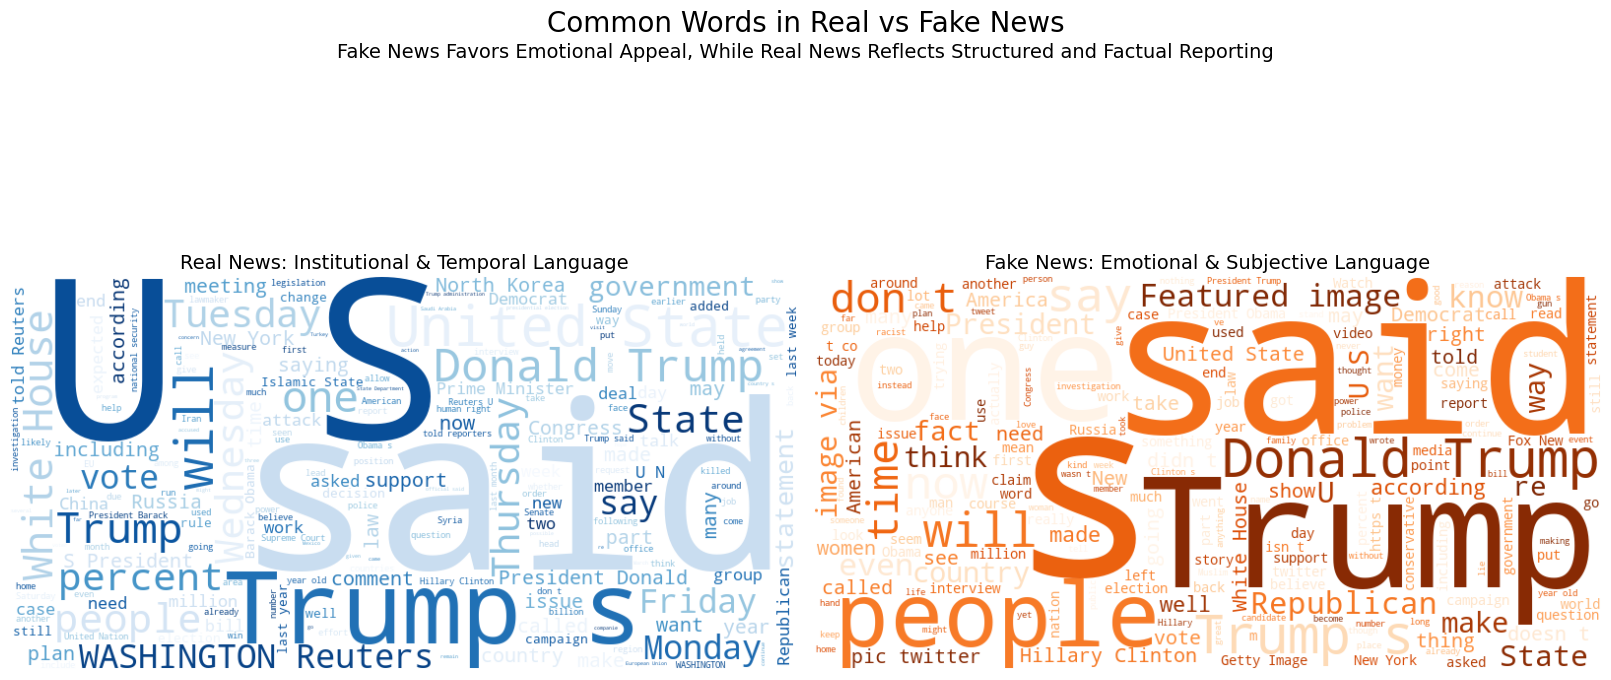

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare text
real_text = " ".join(df_final[df_final['label'] == 0]['text'].astype(str))
fake_text = " ".join(df_final[df_final['label'] == 1]['text'].astype(str))

# Generate word clouds
real_wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(real_text)
fake_wc = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate(fake_text)

# Create figure with constrained layout for better spacing
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
fig.patch.set_facecolor('white')  # set white background

# Plot Real News
axs[0].imshow(real_wc, interpolation='bilinear')
axs[0].set_title("Real News: Institutional & Temporal Language", fontsize=14)
axs[0].axis('off')

# Plot Fake News
axs[1].imshow(fake_wc, interpolation='bilinear')
axs[1].set_title("Fake News: Emotional & Subjective Language", fontsize=14)
axs[1].axis('off')

# Add main title and subtitle
fig.suptitle("Common Words in Real vs Fake News", fontsize=20, y=1.08)
fig.text(0.5, 1.02, 
         "Fake News Favors Emotional Appeal, While Real News Reflects Structured and Factual Reporting", 
         fontsize=14, ha='center')

# Save and show
plt.savefig('../reports/figures/word_cloud.jpg', bbox_inches='tight', dpi=300)
plt.show()


#### Summary: Common Words in Real vs Fake News

1. **"Trump"** dominates both real and fake news, reflecting his central role in political narratives.
2. **Real news** frequently uses formal, time-based, and institutional terms (e.g., *“White House,” “Reuters,” “Tuesday”*), indicating structured and event-driven reporting.
3. **Fake news** shows higher usage of emotional and opinion-oriented words (e.g., *“people,” “want,” “think”*), suggesting an intent to persuade or provoke reactions rather than inform.

---

#### Key Insight:

> Fake news relies more on emotion-driven language, while real news emphasizes facts and institutional reporting.


### 5.6 What are the most common unigrams for real and fake news?

In [57]:
def get_top_n_words(data, n=None):
    vec = CountVectorizer(stop_words='english').fit(data)
    bag = vec.transform(data)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

In [58]:
real_df = pd.DataFrame(get_top_n_words(df_final[df_final['label'] == 0]['text'], 20))
fake_df = pd.DataFrame(get_top_n_words(df_final[df_final['label'] == 1]['text'], 20))


In [67]:


def plot_top_words(word_df, x_label='Frequency', y_label='Word', title='Top Words', file_location=None):
    # Rename columns for consistency
    word_df.columns = ['word', 'freq']
    
    # Generate color palette
    # colors = sns.color_palette("deep", len(word_df))
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=word_df,
        x='freq',
        y='word',
        # hue='word',
        dodge=False
        # palette=colors
    )
    

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

    # Save plot if path is provided
    if file_location:
        plt.savefig(file_location, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {file_location}")

    # Show the plot
    plt.show()


Plot saved to: ../reports/figures/top_20_unigrams_in_real_news.jpg


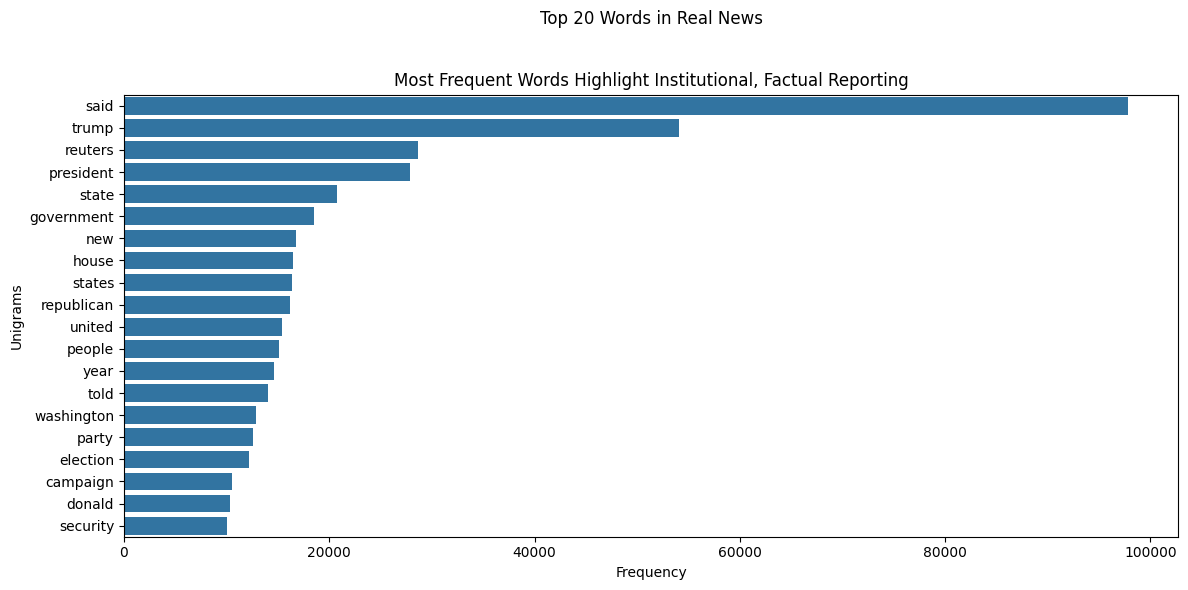

In [73]:
plot_top_words(
    real_df,
    file_location='../reports/figures/top_20_unigrams_in_real_news.jpg',
    title='Top 20 Words in Real News\n\n\nMost Frequent Words Highlight Institutional, Factual Reporting',
    x_label='Frequency',
    y_label='Unigrams',
)

**Most Frequent Words in Real News**

- **Dominant Terms:**  
    "said", "trump", "reuters", and "president" are the most frequent, highlighting a focus on reporting statements, political figures, and news agencies.

- **Institutional Focus:**  
    Words like "government", "state", "house", and "states" reflect coverage of official institutions and events.

- **Consistent, Factual Language:**  
    The vocabulary is formal and event-driven, with little use of emotional or sensational words.

>**Insight:**  Real news emphasizes structured reporting on statements and institutions, supporting factual journalism.

Plot saved to: ../reports/figures/top_20_unigrams_in_fake_news.jpg


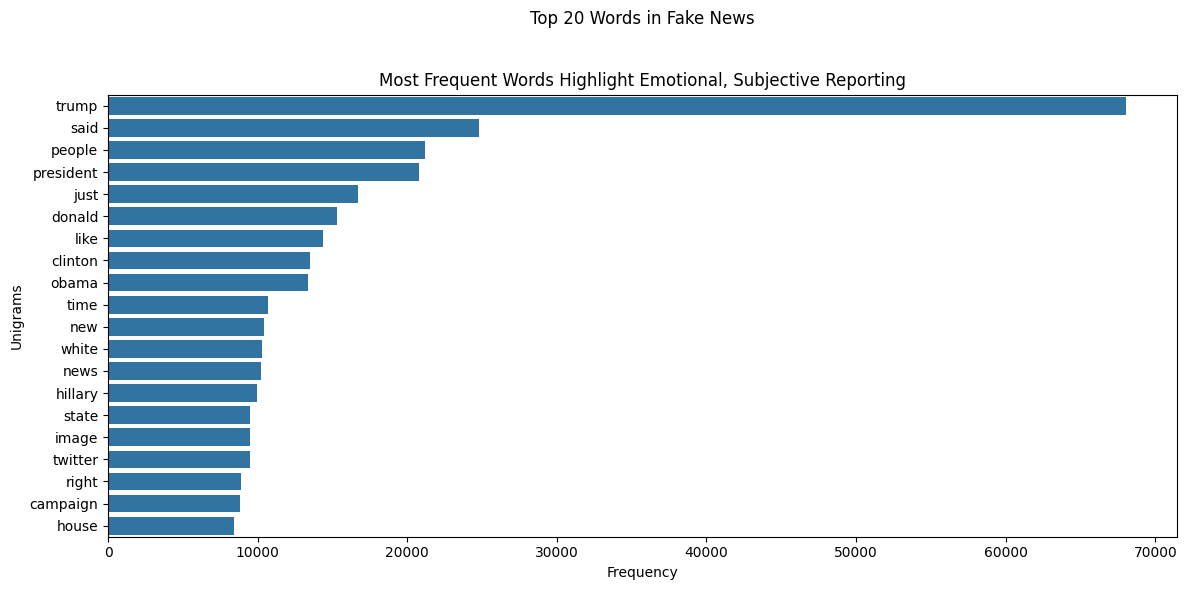

In [72]:
plot_top_words(
    fake_df,
    file_location='../reports/figures/top_20_unigrams_in_fake_news.jpg',
    title='Top 20 Words in Fake News\n\n\nMost Frequent Words Highlight Emotional, Subjective Reporting',
    x_label='Frequency',
    y_label='Unigrams',
)

**Summary: Top 20 Words in Fake News**

- **Most frequent words:** "trump", "said", "people", and "president" dominate, showing a focus on political figures and statements.
- **Emotional and subjective language:** Words like "just", "like", "right", and "think" suggest a more opinionated and persuasive tone.
- **Broader references:** Frequent use of names (e.g., "donald", "clinton", "obama", "hillary") and platforms ("twitter") reflects coverage of personalities and social media.
> **Insight:** Fake news uses more emotional, subjective, and personality-driven language compared to real news.

### 5.3: What are the most common bigrams for real and fake news?

In [74]:
def get_top_n_ngrams(corpus, n=None, ngram_range=(2,2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

In [75]:
real_df_bigrams = pd.DataFrame(get_top_n_ngrams(df_final[df_final['label'] == 0]['text'], 20))
fake_df_bigrams = pd.DataFrame(get_top_n_ngrams(df_final[df_final['label'] == 1]['text'], 20))


Plot saved to: ../reports/figures/top_20_bigrams_in_real_news.jpg


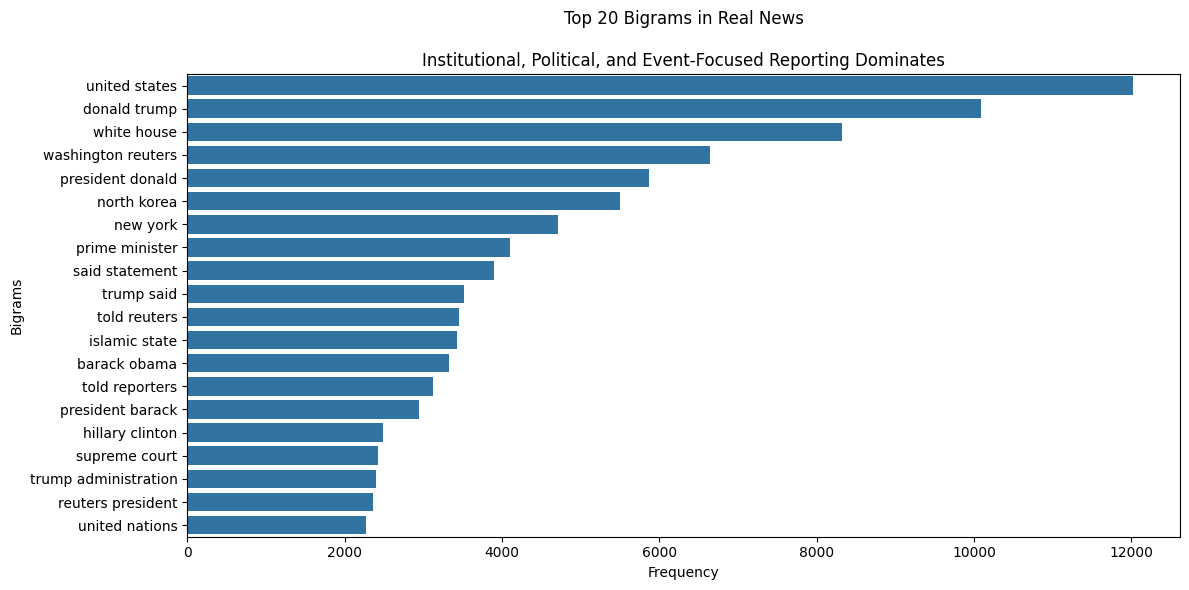

In [109]:
plot_top_words(
    real_df_bigrams,
    title="Top 20 Bigrams in Real News\n\nInstitutional, Political, and Event-Focused Reporting Dominates",
    x_label="Frequency",
    y_label="Bigrams",
    file_location='../reports/figures/top_20_bigrams_in_real_news.jpg'
)

**Summary: Top 20 Bigrams in Real News**

- Dominated by institutional and political phrases (e.g., "united states", "donald trump", "white house").
- Frequent event/location bigrams like "north korea", "new york", and "prime minister".
- Attribution phrases such as "said statement", "told reuters", and "trump said" highlight factual reporting.
- Names of key individuals and legal bodies (e.g., "barack obama", "supreme court") are common.
- Real news bigrams emphasize official sources, events, and structured, factual journalism.


Plot saved to: ../reports/figures/top_20_bigrams_in_fake_news.jpg


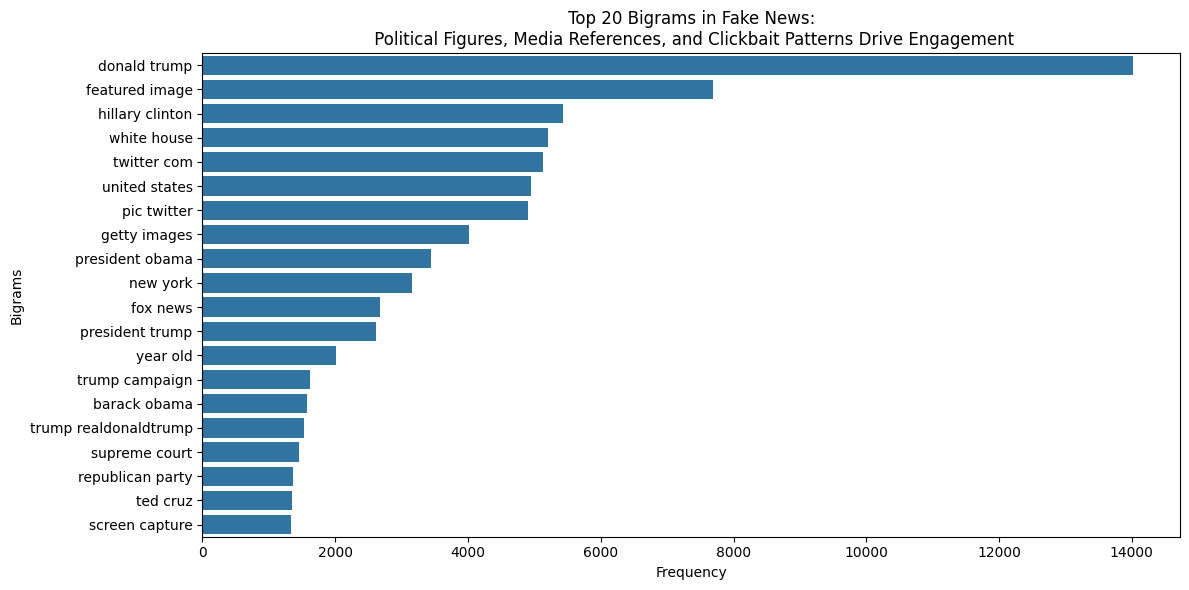

In [110]:
plot_top_words(
    fake_df_bigrams,
    title="Top 20 Bigrams in Fake News:\n Political Figures, Media References, and Clickbait Patterns Drive Engagement",
    x_label="Frequency",
    y_label="Bigrams",
    file_location='../reports/figures/top_20_bigrams_in_fake_news.jpg'
    
)


**Insights from Top 20 Bigrams in Fake News:**

- Focus on political figures (e.g., "donald trump", "hillary clinton") and institutions.
- Frequent media/social media references ("featured image", "twitter com", "fox news").
- Clickbait and sensational phrases ("year old", "screen capture") are common.
- Fake news bigrams blend personalities, media, and sensationalism to drive engagement.
---

## 6: Feature Selection for Modeling

- **Dropped Columns:**  
  The `date` and `day_of_week` columns were removed from the final dataset before modeling.  
  **Reasons:**
  - To prevent data leakage, as publishing day was correlated with the label.
  - To ensure the model learns from content and style, not temporal patterns that may not generalize.
  - To avoid overfitting to historical trends and maintain fairness.

---

### Output: Cleaned Dataset

- The final processed dataset, `cleaned_news.csv`, contains only relevant, non-leaky features and is ready for robust machine learning experiments.
- All engineered metadata features (except those at risk of leakage) are included to support both predictive performance and interpretability.

---


In [102]:
processed_df = df_final.drop(columns=['date', 'day_of_week'], axis=1).reset_index()

In [106]:
processed_df.info(), processed_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38638 entries, 0 to 38637
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    38638 non-null  int64 
 1   title                    38638 non-null  object
 2   text                     38638 non-null  object
 3   subject                  38638 non-null  object
 4   label                    38638 non-null  int64 
 5   text_length              38638 non-null  int64 
 6   title_length             38638 non-null  int64 
 7   exclamations_mark_count  38638 non-null  int64 
 8   questions_mark_count     38638 non-null  int64 
 9   uppercase_words_count    38638 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 2.9+ MB


(None,
 index                      0
 title                      0
 text                       0
 subject                    0
 label                      0
 text_length                0
 title_length               0
 exclamations_mark_count    0
 questions_mark_count       0
 uppercase_words_count      0
 dtype: int64)

In [108]:
processed_df.to_csv('../data/processed/cleaned_news.csv', index=False)


# **Comprehensive EDA Summary: Misinformation Detector Dataset**

---

### 1. **Class Distribution**
- The dataset is **imbalanced**, with real news articles outnumbering fake news. This highlights the need for stratified sampling and careful metric selection (e.g., F1-score) to ensure fair model evaluation.

### 2. **Subject Distribution**
- The `subject` feature is **perfectly correlated** with the target label (e.g., certain subjects only contain fake or real news). This presents a **data leakage risk** and is excluded from model training, though it remains useful for exploratory analysis.

### 3. **Title Length Analysis**
- **Fake news titles** are, on average, **longer and more variable** than real news titles. The presence of extreme outliers suggests that fake news often uses sensational or verbose headlines to attract attention.

### 4. **Text Length Analysis**
- **Fake news articles** tend to be **longer and more variable** in length, with some extremely lengthy entries. Real news articles are more consistent and concise, indicating a more standardized reporting style.

### 5. **Punctuation Usage**
- **Exclamation marks** and **question marks** are used **far more frequently in fake news**. This pattern reflects a tendency toward sensationalism and emotional manipulation in misleading content.

### 6. **Uppercase Words**
- Fake news articles contain **more uppercase words** and show greater variability, likely to emphasize or sensationalize content (e.g., “BREAKING”, “SHOCKING”).

### 7. **Temporal Patterns**
- **Real news** is published more consistently throughout the week, while **fake news spikes on weekends**. This may reflect attempts to exploit higher social media activity or lower editorial oversight during weekends.

### 8. **Word Cloud Insights**
- **Real news** is characterized by institutional, factual, and time-based language (e.g., “White House”, “Reuters”, “Tuesday”).
- **Fake news** relies on emotional, subjective, and opinion-oriented words (e.g., “people”, “want”, “think”), aiming to persuade or provoke.

### 9. **Top Unigrams**
- **Real news**: Focuses on reporting statements, political figures, and institutions with formal, factual language.
- **Fake news**: Uses more emotional, subjective, and personality-driven language, with frequent references to political figures and social media.

### 10. **Top Bigrams**
- **Real news**: Dominated by institutional and political phrases (e.g., “united states”, “donald trump”, “white house”), direct attribution (“said statement”, “told reuters”), and event/location reporting.
- **Fake news**: Blends political figures (“donald trump”, “hillary clinton”), media/image references (“featured image”, “twitter com”, “getty images”), and clickbait phrases (“year old”, “screen capture”), reflecting a strategy to drive engagement through personalities and sensational content.

---

## **Final Narrative & Recommendations**

This EDA reveals a **clear linguistic and structural divide** between real and fake news. Fake news is longer, more sensational, and uses more punctuation, uppercase words, and emotional language. It is also more prevalent on weekends and heavily references political figures, media, and viral content. Real news, in contrast, is concise, consistent, and institution-focused, with language reflecting factual reporting and direct attribution.

**For practitioners:**  
- **Feature engineering** should leverage text length, punctuation, uppercase usage, and temporal patterns.
- **Model evaluation** must address class imbalance and avoid data leakage from features like `subject`.
- **Interpretability** is enhanced by understanding these patterns, enabling better detection and mitigation of misinformation.

**In summary:**  
The dataset provides rich signals for distinguishing fake from real news, supporting the development of robust, interpretable, and fair misinformation detection models.